In [1]:
from dynamic_pricing.db.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn,"nostimo")
print(df.info)

2024-03-03 16:09:55,123 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-03-03 16:09:55,124 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 16:09:55,319 INFO sqlalchemy.engine.Engine select current_schema()
2024-03-03 16:09:55,321 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 16:09:55,516 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-03-03 16:09:55,518 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 16:09:56,408 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-03 16:09:56,409 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [3]:
print(df.columns)
df.head()


Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_quantity',
       'item_fractional_price', 'modifier_id', 'deliveroo_modifier_id',
       'modifier_name', 'modifier_operational_name', 'modifier_quantity',
       'modifier_fractional_price'],
      dtype='object')


,order_id,deliveroo_order_id,deliveroo_order_number,order_status,order_placed_timestamp,order_updated_timestamp,order_prepare_for_timestamp,order_start_prepping_at_timestamp,customer_id,first_name,...,item_name,item_operational_name,item_quantity,item_fractional_price,modifier_id,deliveroo_modifier_id,modifier_name,modifier_operational_name,modifier_quantity,modifier_fractional_price
0,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Chicken Skewer Wrap,Chicken Skewer Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
1,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Chicken Gyros Wrap,Chicken Gyros Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
2,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Pork Skewers Wrap,Pork Skewers Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
3,4,gb:2448923a-6bd3-4100-9f06-033bb09a8456,1847204847,accepted,2023-06-26 17:42:24,2023-06-26 17:43:58,2023-06-26 18:02:36,2023-06-26 17:43:53,None,None,...,Coca Cola Zero,Coca Cola Zero (Soft Drinks),1,280,None,None,None,None,None,None
4,4,gb:2448923a-6bd3-4100-9f06-033bb09a8456,1847204847,accepted,2023-06-26 17:42:24,2023-06-26 17:43:58,2023-06-26 18:02:36,2023-06-26 17:43:53,None,None,...,Greek Salad,Greek Salad (Starters and Sharers),1,1050,None,None,None,None,None,None


Filter to keep only the items we are analyzing

In [4]:
pre_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
pre_dp_df = pre_dp_df[
    (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
    & (pre_dp_df["order_placed_timestamp"] < "2023-7-17")
]
pre_dp_df.info()


post_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
post_dp_df = post_dp_df[
    (post_dp_df["order_placed_timestamp"] >= "2023-7-17")
    & (post_dp_df["order_placed_timestamp"] < "2023-8-07")
]
post_dp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 234
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           64 non-null     int64         
 1   deliveroo_order_id                 64 non-null     object        
 2   deliveroo_order_number             64 non-null     int64         
 3   order_status                       64 non-null     object        
 4   order_placed_timestamp             64 non-null     datetime64[ns]
 5   order_updated_timestamp            64 non-null     datetime64[ns]
 6   order_prepare_for_timestamp        64 non-null     datetime64[ns]
 7   order_start_prepping_at_timestamp  64 non-null     datetime64[ns]
 8   customer_id                        0 non-null      object        
 9   first_name                         0 non-null      object        
 10  contact_number                     0 non-nul

analysis

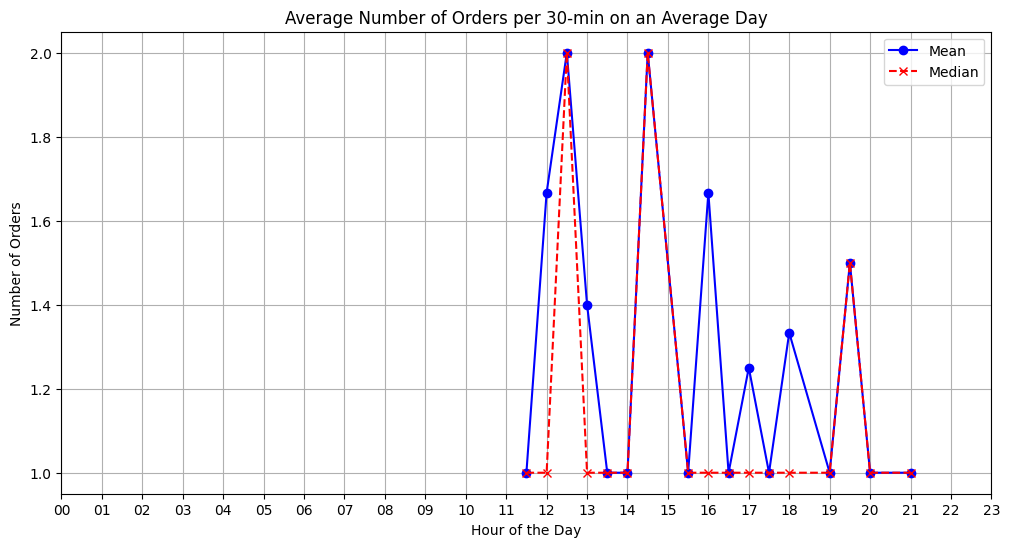

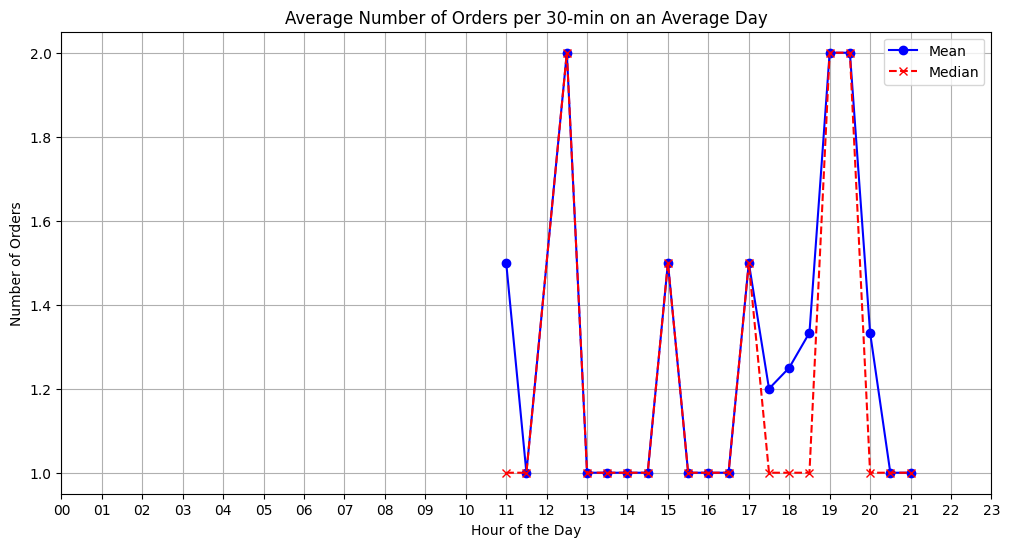

In [5]:
def plot_average_orders_per_interval(df: pd.DataFrame, interval: int):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60
        + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the actual average number of orders for each interval on an average day
    actual_average_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .mean()
    )

    # Calculate the median number of orders for each interval on an average day
    median_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median
    plt.figure(figsize=(12, 6))
    plt.plot(
        actual_average_orders, marker="o", linestyle="-", color="blue", markersize=6, label="Mean"
    )
    plt.plot(
        median_orders, marker="x", linestyle="--", color="red", markersize=6, label="Median"
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Orders")
    plt.title(f"Average Number of Orders per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_orders_per_interval(pre_dp_df, interval=30)
plot_average_orders_per_interval(post_dp_df, interval=30)

/tmp/ipykernel_265870/459708713.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


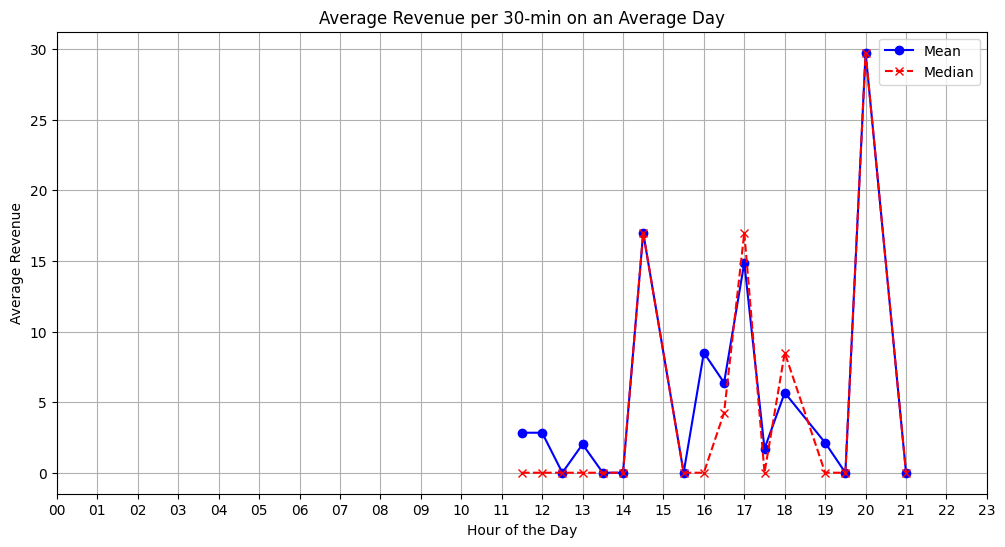

/tmp/ipykernel_265870/459708713.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


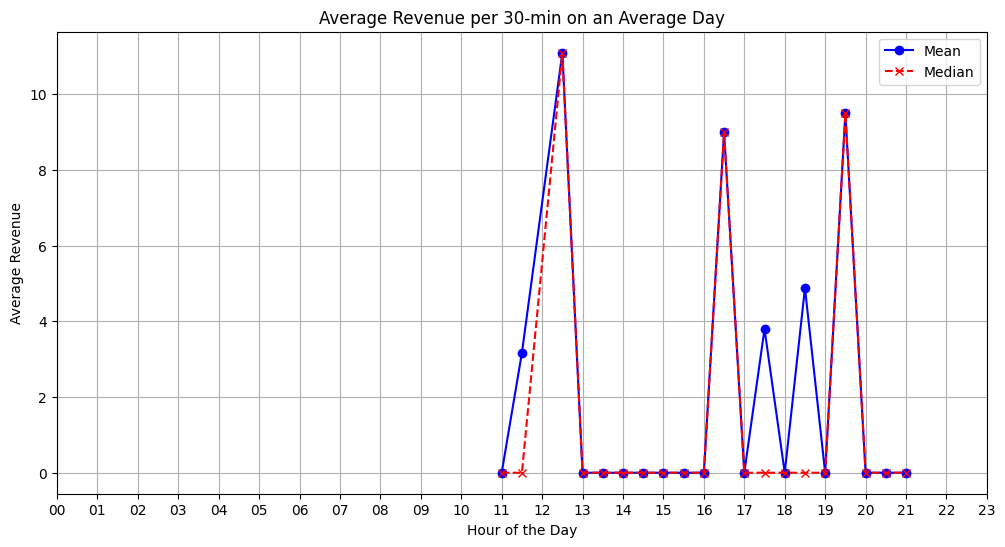

In [6]:
def plot_average_revenue_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Calculate the actual average revenue for each interval on an average day
    df = df[
        [
            "order_id",
            "item_quantity",
            "item_fractional_price",
            "modifier_fractional_price",
            "modifier_quantity",
            order_timestamp,
        ]
    ].copy()
    df.fillna(0, inplace=True)

    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    df["revenue"] = df.groupby("order_id")["order_value"].sum()

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the mean and median revenue for each interval
    mean_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .mean()
    )

    median_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plot both mean and median revenue per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_revenue,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Revenue")
    plt.title(f"Average Revenue per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, int(60 / interval)), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()


plot_average_revenue_per_interval(pre_dp_df, 30)
plot_average_revenue_per_interval(post_dp_df, 30)

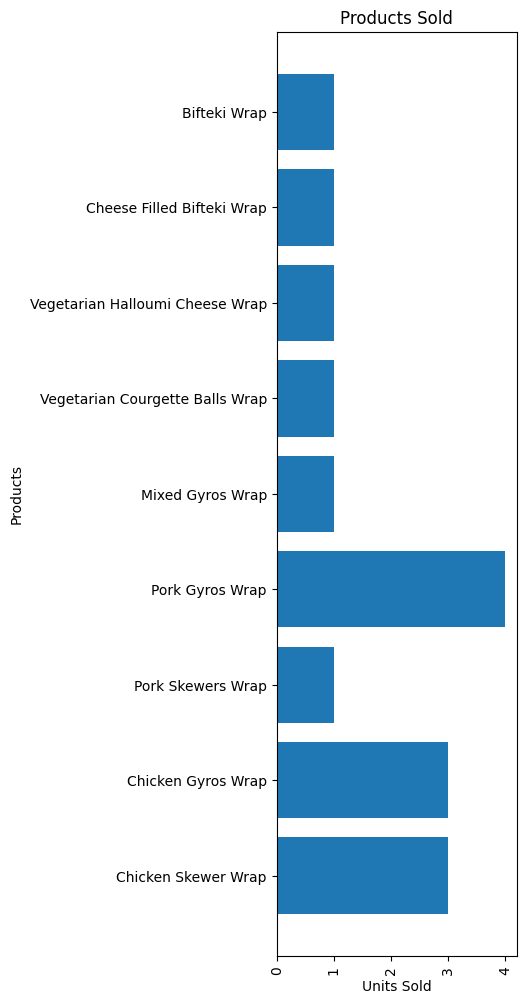

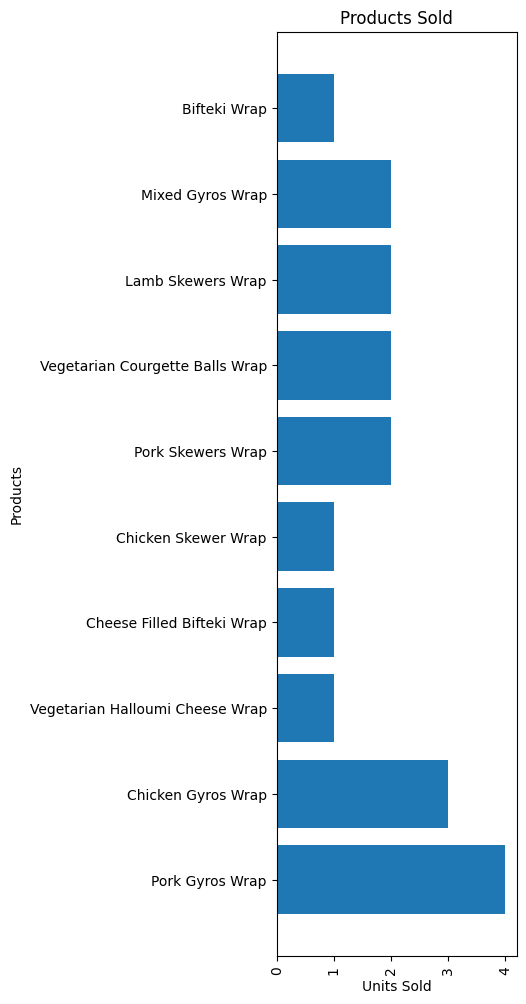

In [8]:
def plot_items_sold(df):
    df = df[["order_id","item_name","item_quantity"]].copy()

    plt.figure(figsize=(6, 12))
    plt.barh(df["item_name"], df["item_quantity"])
    plt.ylabel('Products')
    plt.xlabel('Units Sold')
    plt.title('Products Sold')
    plt.xticks(rotation=90)
    plt.subplots_adjust(left=0.5)  # Adjust the value as needed
    plt.show()

plot_items_sold(pre_dp_df)
plot_items_sold(post_dp_df)

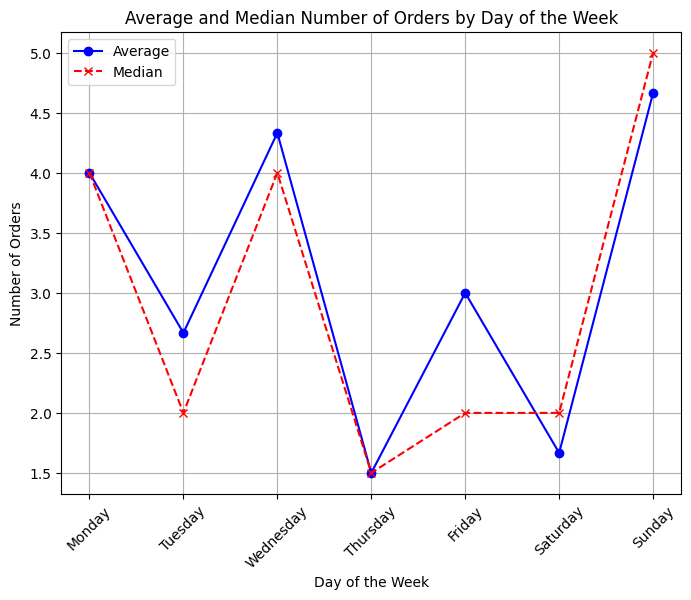

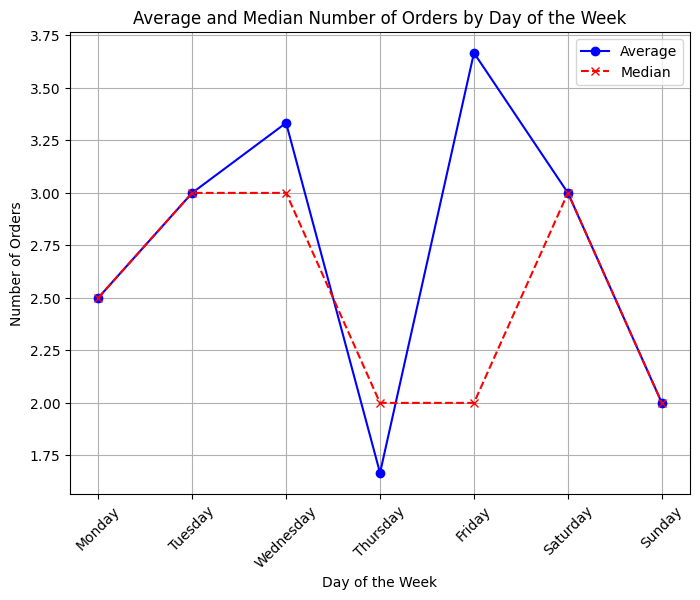

In [9]:
def plot_average_orders_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    # Group by day of the week and calculate both average and median number of orders
    average_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .mean()
    )
    median_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_orders = average_orders.reindex(weekdays)
    median_orders = median_orders.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both average and median number of orders by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_orders,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Average",
    )
    plt.plot(
        median_orders,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Orders")
    plt.title("Average and Median Number of Orders by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()


plot_average_orders_by_day_of_week(pre_dp_df)
plot_average_orders_by_day_of_week(post_dp_df)

/tmp/ipykernel_265870/4064468226.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


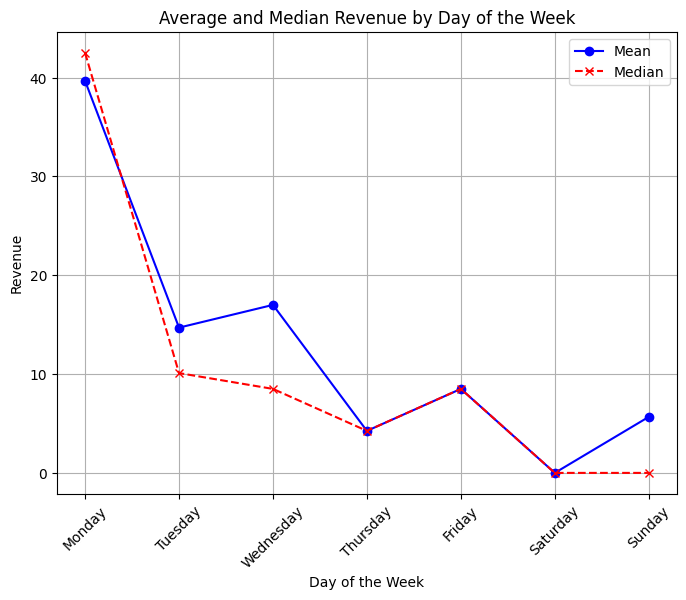

/tmp/ipykernel_265870/4064468226.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


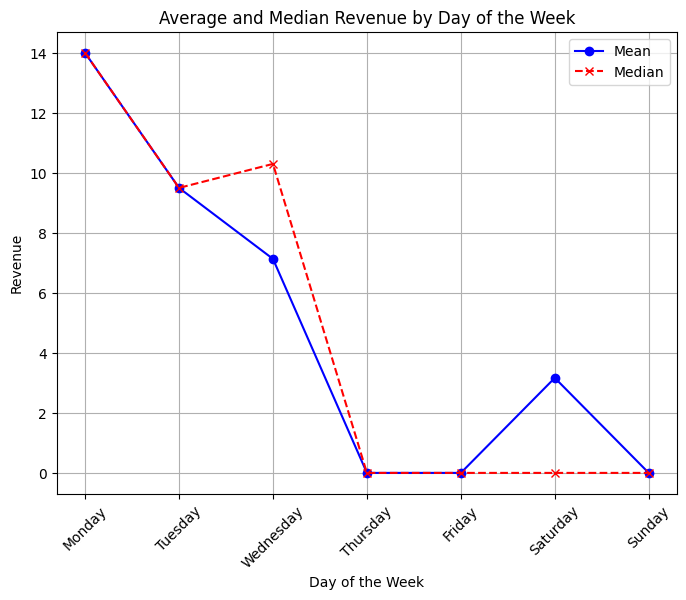

In [10]:
def plot_average_revenue_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Calculate the average revenue by day of the week
    df = df[
        [
            "order_id",
            "item_quantity",
            "item_fractional_price",
            "modifier_fractional_price",
            "modifier_quantity",
            order_timestamp,
        ]
    ].copy()
    df.fillna(0, inplace=True)

    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    df["revenue"] = df.groupby("order_id")["order_value"].sum()

    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    average_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .mean()
    )
    median_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_revenue_by_day = average_revenue_by_day.reindex(weekdays)
    median_revenue_by_day = median_revenue_by_day.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both mean and median revenue by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_revenue_by_day,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue_by_day,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Revenue")
    plt.title("Average and Median Revenue by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()


plot_average_revenue_by_day_of_week(pre_dp_df)
plot_average_revenue_by_day_of_week(post_dp_df)

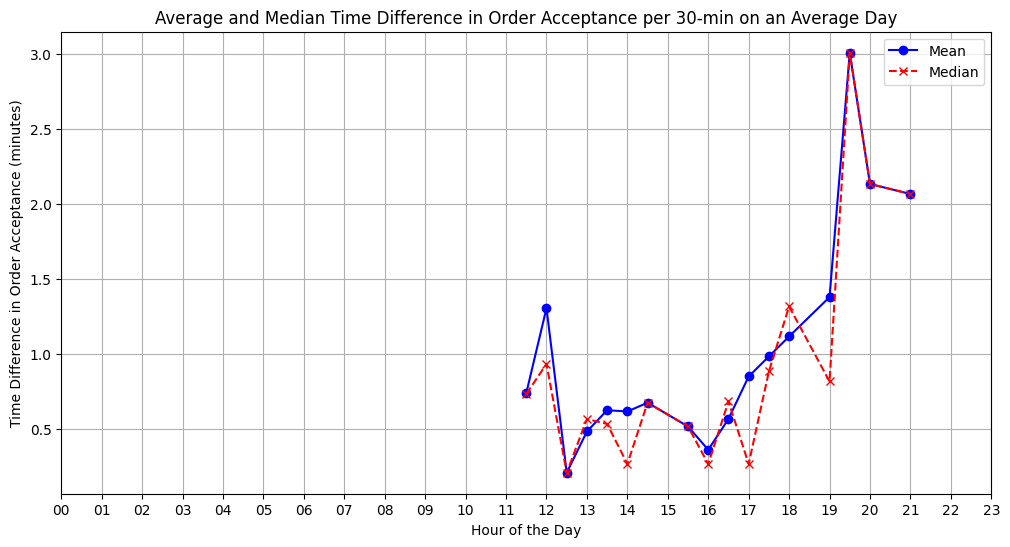

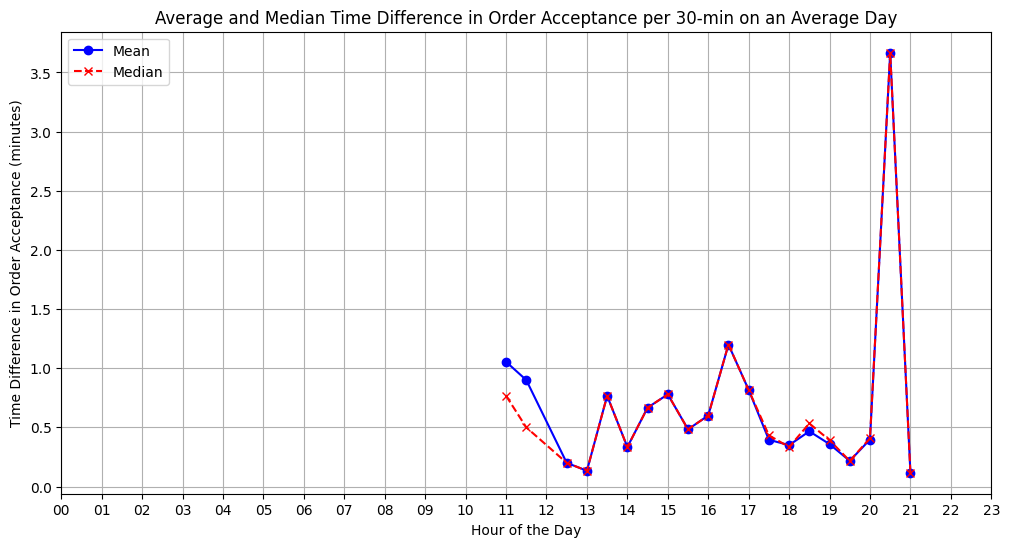

In [11]:
def time_difference_in_order_acceptance_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    accepted_timestamp = "order_updated_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[accepted_timestamp] - df[order_timestamp]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median time difference in order acceptance per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Time Difference in Order Acceptance (minutes)")
    plt.title(
        f"Average and Median Time Difference in Order Acceptance per {interval}-min on an Average Day"
    )
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()


time_difference_in_order_acceptance_per_interval(pre_dp_df, 30)
time_difference_in_order_acceptance_per_interval(post_dp_df, 30)

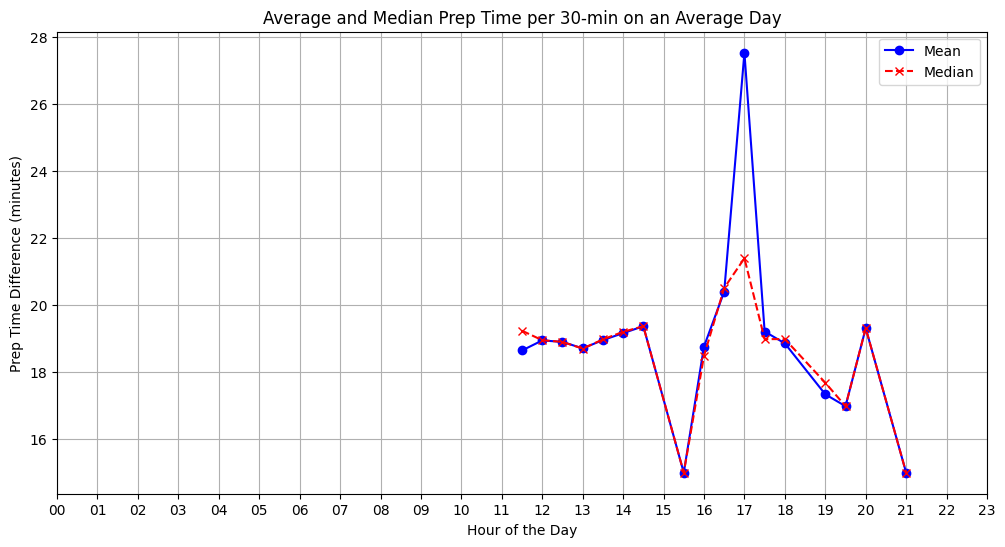

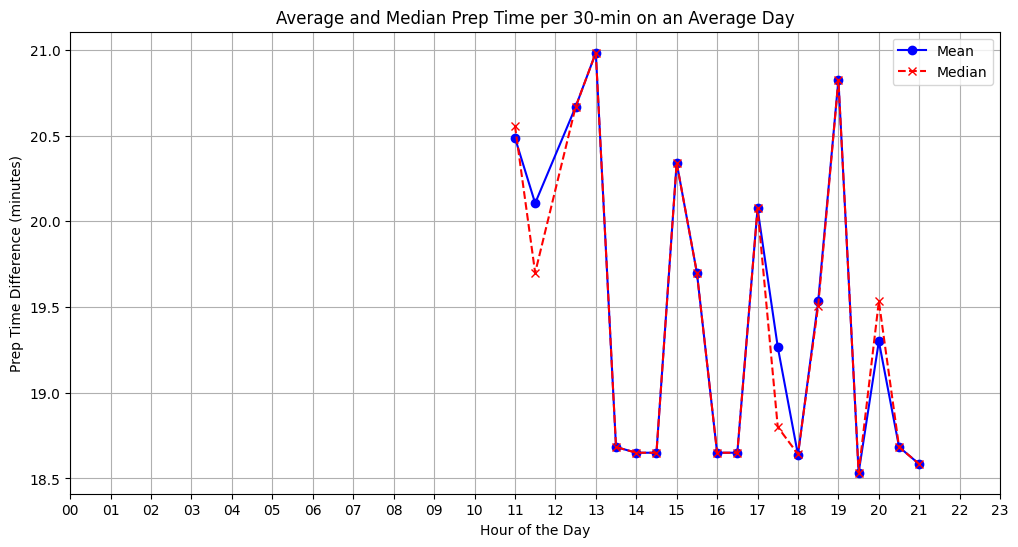

In [12]:
def prep_time_per_interval(df, interval):
    """Use https://api-docs.deliveroo.com/v2.0/docs/order-integration to understand why these timestamps are used"""
    start_prep_time = "order_start_prepping_at_timestamp"
    end_prep_time = "order_prepare_for_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[start_prep_time].dt.hour * 60 + df[start_prep_time].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[end_prep_time] - df[start_prep_time]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median prep time per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Prep Time Difference (minutes)")
    plt.title(f"Average and Median Prep Time per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()


prep_time_per_interval(pre_dp_df, 30)
prep_time_per_interval(post_dp_df, 30)

checkout any major events 
look at seasionality of the month